# Post-Bining: Experimental Place Cells

This notebook reads an experimental dataset after:
- cell firings,
- labels,
- times,
have been binned according to a given time-step `timestep_microsec`.

Specifically, we read the files obtained after the processing function `experimental.datasets.load_place_cells` that:
- bins cell firings, times and labels according to the time-step,
- save the results in 3 files.

Plotting the binned files allows us to determine how many neurons were recorded in each experiment.


Runtime: This notebook takes 1 minute to run on a 32 CPUs server if the data is already preprocessed and stored in the npy, txt files.

## Set up

In [1]:
import os
import subprocess

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

import warnings

warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


## Imports

In [2]:
import glob
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import neuralgeom.datasets.experimental as experimental
import neuralgeom.datasets.utils as utils

RAW_DIR = os.path.join(os.getcwd(), "data", "raw")
print(f"The raw data is located in the directory:\n{RAW_DIR}.")
BINNED_DIR = os.path.join(os.getcwd(), "data", "binned")
print(f"The binned data is located in the directory:\n{BINNED_DIR}.")

INFO: Using pytorch backend


The raw data is located in the directory:
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw.
The binned data is located in the directory:
/home/nmiolane/code/neuralgeom/neuralgeom/data/binned.


## Preprocess all experiments 

We show all the raw data available in the `data/raw/` folder.

In [3]:
string_base = os.path.join(RAW_DIR, "expt*.mat")
print(string_base)
paths = sorted(glob.glob(string_base))

print(f"Raw data in directory {RAW_DIR}:")
for path in paths:
    print(path)

/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt*.mat
Raw data in directory /home/nmiolane/code/neuralgeom/neuralgeom/data/raw:
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt10.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt10_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt11.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt11_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt12.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt12_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt13.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt13_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt14.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt14_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt15.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt15_hd.mat
/home/nmiolane/code/neuralgeom/neuralgeom/data/raw/expt16.mat
/home/nmiolane/code/neuralgeom/neuralgeom

We extract a list of available experiment IDs, using the paths .mat available in the `data/raw/` folder.

In [4]:
expt_ids = []
for path in paths:
    basename = os.path.basename(path).split(".")[0]
    expt_id = basename[4:]
    expt_ids.append(expt_id)

### Get number of times after binning with a given timestep

We decide on a time step to bin the raw data.

In [5]:
timestep_ns = int(1e5)

We use joblib to parallelize the preprocessing on many CPUs. With the parameter n_jobs=-1, we use as many CPUs as are available, i.e. 32 on our server.

Here, we extract the number of times (i.e. the number of data points) after binning with the time step chosen.

In [6]:
from joblib import Parallel, delayed


def bin_place_cells(expt_id):
    print(f"Processing expt {expt_id} at timestep {timestep_ns}...")

    try:
        place_cells, labels = experimental.load_place_cells(
            expt_id=expt_id, timestep_microsec=timestep_ns
        )
        return {expt_id: place_cells.shape[0]}
    except Exception:
        print(f"!! Error for {basename}")
        return {expt_id: -1}


results = Parallel(n_jobs=-1)(delayed(bin_place_cells)(expt_id) for expt_id in expt_ids)

INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_times_timestep100000.txt! Loading...
INFO: Using pytorch backend
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_place_cells_timestep100000.npy! Loading...
INFO: # - Found 

We save the preprocessing (here, number of times available after binning) results into a `.csv` file

In [7]:
import pandas as pd

expt_to_ntimes_dict = {}
for one_result in results:
    for expt_id, ntimes in one_result.items():
        expt_to_ntimes_dict["expt" + expt_id] = ntimes

expt_to_ntimes = pd.DataFrame.from_dict(
    expt_to_ntimes_dict, orient="index", columns=[f"ntimes (timestep = {timestep_ns})"]
)
expt_to_ntimes

,ntimes (timestep = 100000)
expt10,20555
expt10_hd,17827
expt11,33836
expt11_hd,13802
expt12,29825
...,...
expt7,39005
expt7_hd,23595
expt8,24489
expt9,25946


In [8]:
path = os.path.join(os.getcwd(), f"data/expt_to_ntimes_timestep{timestep_ns}.csv")
print(
    f"Saving the number of times per experiment for timestep {timestep_ns} to: {path}."
)
expt_to_ntimes.to_csv(path)

Saving the number of times per experiment for timestep 100000 to: /home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_ntimes_timestep100000.csv.


### Get values of the gains

We extract the one, or two, main values of the gain within each experiment.

In [9]:
first_gains = []
second_gains = []
for expt_id in expt_ids:
    _, labels = experimental.load_place_cells(
        expt_id=expt_id, timestep_microsec=timestep_ns
    )
    gain_counts = labels["gains"].value_counts()
    if gain_counts.is_unique:
        first_gains.append(gain_counts.index[0])
        second_gains.append("NA")
    else:
        first_gains.append(gain_counts.index[0])
        second_gains.append(gain_counts.index[1])

INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_times_timestep100000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_place_cells_timestep100000.npy! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_labels_timestep100000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_times_timestep100000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_place_cells_timestep100000.npy! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt10_hd_labels_timestep100000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt11_times_timestep100000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt11_place_cells_timestep100000.npy! Loadin

We save this summary statistics into a `.csv` file.

In [10]:
expts = ["expt" + expt_id for expt_id in expt_ids]
expt_to_first_second_gains = pd.DataFrame(
    data={"first_gain": first_gains, "second_gain": second_gains}, index=expts
)

In [11]:
expt_to_first_second_gains

,first_gain,second_gain
expt10,0.846,1.0
expt10_hd,1.000,1.154
expt11,1.461,1.0
expt11_hd,1.000,0.846
expt12,0.231,1.0
...,...,...
expt7,0.231,1.0
expt7_hd,1.000,1.462
expt8,1.769,1.0
expt9,1.154,1.0


In [12]:
path = os.path.join(os.getcwd(), f"data/expt_to_first_second_gains.csv")
print(f"Saving the values of the two gains for each expt to: {path}.")
expt_to_first_second_gains.to_csv(path)

Saving the values of the two gains for each expt to: /home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_first_second_gains.csv.


### Get number of lab loop (i.e. laps) performed

In [13]:
def _get_n_laps(absolute_angles):
    """Return the number of laps.

    Note: this assumes that the angles are *not* given modulo 360,
    and uses the raw angles that are not modulo-ed.

    Note: this does not work for gain = 1 since gain is often 1 at the start
    and at the end of an experiment.
    """
    return (np.max(absolute_angles) - np.min(absolute_angles)) // 360


def get_n_laps(expt_id):
    expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))
    rosdata = expt["x"]["rosdata"]
    enctimes = rosdata["encTimes"]
    encangles = rosdata["encAngle"]
    gains = rosdata["gain"]

    n_laps_total = _get_n_laps(encangles)
    n_times_total = len(encangles)

    uniques, gain_counts = np.unique(gains, return_counts=True)
    gain_counts_sorted = sorted(gain_counts)
    uniques_sorted = uniques[gain_counts.argsort()]
    gain_counts_reverse = gain_counts_sorted[::-1]
    uniques_reverse = uniques_sorted[::-1]

    n_times_other_gain = 0
    if len(uniques_reverse) > 1:
        other_gain = uniques_reverse[1]
        n_times_other_gain = gain_counts_reverse[1]
        if other_gain == 1.0:
            other_gain = uniques_reverse[0]
            n_times_other_gain = gain_counts_reverse[0]
        print(
            f"\nExpt {expt_id}: Found another gain: {other_gain} (Counts: {n_times_other_gain})."
        )
        encangles_other_gain = np.array(
            [
                a
                for (a, g) in zip(encangles, gains)
                if np.isclose(g, other_gain, atol=0.01)
            ]
        )
        n_laps_other_gain = _get_n_laps(encangles_other_gain)
    else:
        print(f"\nExpt {expt_id}: Only one gain!")
        n_laps_other_gain = 0
    return {
        expt_id: {
            "n_laps_total": n_laps_total,
            "n_laps_other_gain": n_laps_other_gain,
            "n_times_total": int(n_times_total),
            "n_times_other_gain": int(n_times_other_gain),
        }
    }


results = Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(get_n_laps)(expt_id) for expt_id in expt_ids
)


Expt 16_hd: Found another gain: 1.153999999165535 (Counts: 45729).

Expt 17: Only one gain!
Expt 2: Only one gain!
Expt 11_hd: Found another gain: 0.846000000834465 (Counts: 39610).

Expt 30_hd: Found another gain: 1.4620000123977661 (Counts: 40719).
Expt 11: Found another gain: 1.460999995470047 (Counts: 221792).


Expt 12: Found another gain: 0.23100000619888306 (Counts: 168497).


Expt 10: Found another gain: 0.846000000834465 (Counts: 158833).
Expt 28_hd: Found another gain: 0.23100000619888306 (Counts: 50742).

Expt 15: Found another gain: 0.10000002384185791 (Counts: 214206).



Expt 15_hd: Found another gain: 1.768999993801117 (Counts: 41773).
Expt 14: Found another gain: 0.539000004529953 (Counts: 176966).


Expt 10_hd: Found another gain: 1.153999999165535 (Counts: 46630).
Expt 31_hd: Found another gain: 0.100047767162323 (Counts: 182).
Expt 34_hd: Found another gain: 0.10000050067901611 (Counts: 374).

Expt 12_hd: Found another gain: 1.4620000123977661 (Counts: 48017).
Expt 

We save this summary statistics in a `.csv` file.

In [14]:
import pandas as pd

expt_to_n_laps_dict = {}
for one_result in results:
    for expt_id, n_laps_dict in one_result.items():
        expt_to_n_laps_dict["expt" + expt_id] = n_laps_dict

expt_to_n_laps = pd.DataFrame.from_dict(
    expt_to_n_laps_dict,
    orient="index",
    columns=[
        "n_laps_total",
        "n_laps_other_gain",
        "n_times_total",
        "n_times_other_gain",
    ],
)
expt_to_n_laps

,n_laps_total,n_laps_other_gain,n_times_total,n_times_other_gain
expt10,84.0,62.0,208236,158833
expt10_hd,94.0,26.0,178311,46630
expt11,100.0,61.0,341121,221792
expt11_hd,86.0,26.0,138026,39610
expt12,131.0,77.0,302405,168497
...,...,...,...,...
expt7,147.0,93.0,391228,257916
expt7_hd,95.0,26.0,232760,46761
expt8,141.0,87.0,246866,155299
expt9,74.0,51.0,259599,198060


In [15]:
path = os.path.join(os.getcwd(), f"data/expt_to_n_laps.csv")
print(
    f"Saving the number of laps (total and per gain) by the rat for each expt to: {path}."
)
expt_to_n_laps.to_csv(path)

Saving the number of laps (total and per gain) by the rat for each expt to: /home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_n_laps.csv.


## Explore one experimental dataset output by experimental.load_place_cells()

In [16]:
expt_id = 41
timestep_ns = int(1e6)

print(f"Loading experiment {expt_id}...")
place_cells, labels = experimental.load_place_cells(
    expt_id=expt_id, timestep_microsec=timestep_ns
)

INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_labels_timestep1000000.txt! Loading...


Loading experiment 41...


In [17]:
print(place_cells.shape)
place_cells[:3]

(3882, 12)


array([[0., 4., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.]])

In [18]:
print(len(labels.values))

display(labels)

3882


,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,218.096356,14.498892,1.000
1,1,2.399831e+09,228.319574,1.598267,1.000
2,2,2.400831e+09,229.646926,6.372364,1.000
3,3,2.401831e+09,241.624300,17.123473,1.000
4,4,2.402831e+09,269.453404,32.549442,1.000
...,...,...,...,...,...
3877,3877,6.275831e+09,153.349456,23.023874,1.769
3878,3878,6.276831e+09,180.073147,32.645234,1.769
3879,3879,6.277831e+09,212.383674,20.877510,1.769
3880,3880,6.278831e+09,218.709534,1.998074,1.769


In [19]:
gain_counts = labels["gains"].value_counts()
print(gain_counts)

1.769000    2938
1.000000     219
1.300835       4
1.300840       3
1.282311       2
            ... 
1.300842       1
1.300836       1
1.300833       1
1.300830       1
1.767975       1
Name: gains, Length: 721, dtype: int64


In [20]:
labels["gains"].value_counts().is_unique

False

### Filter by velocities

In [21]:
filtered_place_cells = place_cells[labels["velocities"] > 5]
filtered_labels = labels[labels["velocities"] > 5]

print(len(filtered_place_cells))
print(len(filtered_labels))

filtered_place_cells = place_cells[labels["velocities"] > 10]
filtered_labels = labels[labels["velocities"] > 10]

print(len(filtered_place_cells))
print(len(filtered_labels))

1200
1200
935
935


### Filter by gain

In [22]:
filtered_place_cells = place_cells[labels["gains"] == 1.0]
filtered_labels = labels[labels["gains"] == 1.0]

print(len(filtered_place_cells))
print(len(filtered_labels))

219
219


In [23]:
filtered_place_cells = place_cells[labels["gains"] == 1.768999993801117]
filtered_labels = labels[labels["gains"] == 1.768999993801117]

print(len(filtered_place_cells))
print(len(filtered_labels))

2938
2938


### PCA


In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(place_cells)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
projected = pca.fit_transform(place_cells)

[0.33181392 0.21530291]
0.5471168343589183


In [25]:
import torch

U, S, V = torch.pca_lowrank(torch.tensor(place_cells), q=8, center=True)

## Explore one experimental dataset saved in the place cells' npy, the times' txt and the labels' txt.

In [26]:
data_path = os.path.join(
    BINNED_DIR, f"expt{expt_id}_place_cells_timestep{timestep_ns}.npy"
)
times_path = os.path.join(BINNED_DIR, f"expt{expt_id}_times_timestep{timestep_ns}.txt")
labels_path = os.path.join(
    BINNED_DIR, f"expt{expt_id}_labels_timestep{timestep_ns}.txt"
)

In [27]:
print(f"Loading experiment {expt_id}...")
place_cells = np.load(data_path)

print(place_cells.shape)
print(place_cells[:3])

Loading experiment 41...
(3882, 12)
[[0. 4. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]]


In [28]:
times = pd.read_csv(times_path)
times

,2.398831347000000000e+09
0,2.399831e+09
1,2.400831e+09
2,2.401831e+09
3,2.402831e+09
4,2.403831e+09
...,...
3877,6.276831e+09
3878,6.277831e+09
3879,6.278831e+09
3880,6.279831e+09


In [29]:
labels = pd.read_csv(labels_path)
labels

,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,218.096356,14.498892,1.000
1,1,2.399831e+09,228.319574,1.598267,1.000
2,2,2.400831e+09,229.646926,6.372364,1.000
3,3,2.401831e+09,241.624300,17.123473,1.000
4,4,2.402831e+09,269.453404,32.549442,1.000
...,...,...,...,...,...
3877,3877,6.275831e+09,153.349456,23.023874,1.769
3878,3878,6.276831e+09,180.073147,32.645234,1.769
3879,3879,6.277831e+09,212.383674,20.877510,1.769
3880,3880,6.278831e+09,218.709534,1.998074,1.769


## Explore one dataset given to the training

In [30]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    print(config_file)

Config in directory: /home/nmiolane/code/neuralgeom/neuralgeom/results/configs:
run_1e6107ad_experimental_41_gain_1.json
run_10cb6cd9_s1_synthetic_noise_var_0.001_embedding_dim_3.json
run_b9ee91bf_experimental_41_other_gain.json
run_2615720a_experimental_41_other_gain.json
run_4df76f48_experimental_53_hd_gain_1.json
run_e88ec067_s1_synthetic_noise_var_0.1_embedding_dim_8.json
run_036b7eff_experimental_41_other_gain.json
run_4fc14a2b_experimental_41_gain_1.json
run_5e33cc64_experimental_41_gain_1.json
run_67f95946_experimental_41_gain_1.json
run_90a77a32_s1_synthetic_noise_var_0.1_embedding_dim_20.json
run_bc00edc9_s1_synthetic_noise_var_0.001_embedding_dim_10.json
run_90bbee31_experimental_53_hd_gain_1.json
run_a3fd380f_s1_synthetic_noise_var_0.01_embedding_dim_50.json
run_d4a3fe52_s1_synthetic_noise_var_0.001_embedding_dim_8.json
run_282623de_experimental_41_gain_1.json
run_f075ec2c_experimental_41_gain_1.json
run_b40d1190_experimental_53_hd_gain_1.json
run_cd60dd01_experimental_41_ga

In [31]:
with open(
    os.path.join(CONFIG_DIR, "run_1e6107ad_experimental_41_gain_1.json"), "r"
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)

In [32]:
config

{'batch_size': 32,
 'decoder_depth': 100,
 'decoder_width': 100,
 'encoder_depth': 4,
 'encoder_width': 100,
 'lr': 0.005502811779723158,
 'dataset_name': 'experimental',
 'sweep_name': 'experimental_41_gain_1',
 'expt_id': '41',
 'timestep_microsec': 100000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'distortion_amp': None,
 'noise_var': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cuda',
 'log_interval': 20,
 'checkpt_interval': 20,
 'scheduler': False,
 'n_epochs': 150,
 'beta': 0.03,
 'gamma': 30,
 'sftbeta': 4.5,
 'gen_likelihood_type': 'gaussian',
 'gain': 1,
 'run_name': 'run_1e6107ad_experimental_41_gain_1',
 'results_prefix': 'run_1e6107ad_experimental_41_gain_1',
 'data_n_times': 828,
 'data_dim': 12}

In [33]:
data, labels, train_loader, test_loader = utils.load(config)

INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_times_timestep100000.txt! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_place_cells_timestep100000.npy! Loading...
INFO: # - Found file at /home/nmiolane/code/neuralgeom/neuralgeom/data/binned/expt41_labels_timestep100000.txt! Loading...


The dataset transitions between two gains: 1.769000 and 1.000000.
We select gain 1: gain = 1.
Dataset shape: (828, 12).


In [34]:
print(data.shape)
data[:3]

torch.Size([828, 12])


tensor([[0.1953, 0.3093, 0.1953, 0.0000, 0.0345, 0.3838, 0.1953, 0.1953, 0.1953,
         0.1953, 0.1973, 0.1953],
        [0.1953, 0.3019, 0.1953, 0.0396, 0.0605, 0.3748, 0.1953, 0.1953, 0.1953,
         0.1953, 0.1974, 0.1953],
        [0.1953, 0.2948, 0.1953, 0.0775, 0.0860, 0.3661, 0.1953, 0.1953, 0.1953,
         0.1953, 0.1977, 0.1953]], dtype=torch.float32)

In [35]:
labels

,Unnamed: 0,times,angles,velocities,gains
0,0,2.398831e+09,212.353925,7.963172,1.0
3,3,2.399131e+09,214.237910,17.439331,1.0
4,4,2.399231e+09,216.532059,24.942784,1.0
5,5,2.399331e+09,218.856971,21.678233,1.0
6,6,2.399431e+09,220.801743,17.698805,1.0
...,...,...,...,...,...
2151,2151,2.613931e+09,202.665281,19.557472,1.0
2187,2187,2.617531e+09,205.206956,5.135445,1.0
2188,2188,2.617631e+09,206.335276,16.544086,1.0
2189,2189,2.617731e+09,208.481443,26.560604,1.0


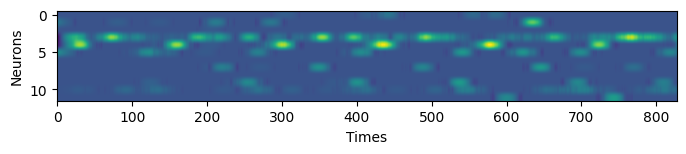

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(data[:1000, :].T, aspect=10)
ax.set_xlabel("Times")
ax.set_ylabel("Neurons");

## Assemble all summary statistics table into one .csv

In [39]:
DATA_DIR = os.path.join(os.getcwd(), "data")

string_base = os.path.join(DATA_DIR, "expt*.csv")

paths = sorted(glob.glob(string_base))
dfs = []
for path in paths:
    print(path)
    df = pd.read_csv(path)
    df.reset_index(inplace=True)
    df = df.drop(columns=["index"]).rename(columns={"Unnamed: 0": "expt_id"})
    dfs.append(df)
    display(df.head())


from functools import reduce

final_df = reduce(lambda x, y: pd.merge(x, y, on="expt_id"), dfs)
final_df

/home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_first_second_gains.csv


,expt_id,first_gain,second_gain
0,expt10,0.846,1.000
1,expt10_hd,1.000,1.154
2,expt11,1.461,1.000
3,expt11_hd,1.000,0.846
4,expt12,0.231,1.000


/home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_n_laps.csv


,expt_id,n_laps_total,n_laps_other_gain,n_times_total,n_times_other_gain
0,expt10,84.0,62.0,208236,158833
1,expt10_hd,94.0,26.0,178311,46630
2,expt11,100.0,61.0,341121,221792
3,expt11_hd,86.0,26.0,138026,39610
4,expt12,131.0,77.0,302405,168497


/home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_ncells.csv


,expt_id,ncells
0,expt10,15
1,expt10_hd,30
2,expt11,11
3,expt11_hd,25
4,expt12,11


/home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_ntimes_timestep100000.csv


,expt_id,ntimes (timestep = 100000)
0,expt10,20555
1,expt10_hd,17827
2,expt11,33836
3,expt11_hd,13802
4,expt12,29825


/home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_ntimes_timestep1000000.csv


,expt_id,ntimes (timestep = 1000000)
0,expt10,2055
1,expt10_hd,1782
2,expt11,3383
3,expt11_hd,1380
4,expt12,2982


,expt_id,first_gain,second_gain,n_laps_total,n_laps_other_gain,n_times_total,n_times_other_gain,ncells,ntimes (timestep = 100000),ntimes (timestep = 1000000)
0,expt10,0.846,1.000,84.0,62.0,208236,158833,15,20555,2055
1,expt10_hd,1.000,1.154,94.0,26.0,178311,46630,30,17827,1782
2,expt11,1.461,1.000,100.0,61.0,341121,221792,11,33836,3383
3,expt11_hd,1.000,0.846,86.0,26.0,138026,39610,25,13802,1380
4,expt12,0.231,1.000,131.0,77.0,302405,168497,11,29825,2982
...,...,...,...,...,...,...,...,...,...,...
59,expt7,0.231,1.000,147.0,93.0,391228,257916,12,39005,3900
60,expt7_hd,1.000,1.462,95.0,26.0,232760,46761,31,23595,2359
61,expt8,1.769,1.000,141.0,87.0,246866,155299,12,24489,2448
62,expt9,1.154,1.000,74.0,51.0,259599,198060,20,25946,2594


In [40]:
path = os.path.join(os.getcwd(), f"data/expt_to_summary.csv")
print(
    f"Saving the summary statistics into a master csv file at: {path}."
)
final_df.to_csv(path)

Saving the summary statistics into a master csv file at: /home/nmiolane/code/neuralgeom/neuralgeom/data/expt_to_summary.csv.
